## 目录
1. 因子参数优化
2. 事件参数优化
3. 拓展：外部自定义带参算法优化

In [1]:
from jaqs.data import DataView 
import warnings

warnings.filterwarnings("ignore")
dataview_folder = '../../Factor'
dv = DataView()
dv.load_dataview(dataview_folder)

Dataview loaded successfully.


In [2]:
import numpy as np

def mask_index_member():
    df_index_member = dv.get_ts('index_member')
    mask_index_member = ~(df_index_member >0) #定义信号过滤条件-非指数成分
    return mask_index_member

def limit_up_down():
    # 定义可买卖条件——未停牌、未涨跌停
    trade_status = dv.get_ts('trade_status')
    mask_sus = trade_status == u'停牌'
    # 涨停
    dv.add_formula('up_limit', '(close - Delay(close, 1)) / Delay(close, 1) > 0.095', is_quarterly=False)
    # 跌停
    dv.add_formula('down_limit', '(close - Delay(close, 1)) / Delay(close, 1) < -0.095', is_quarterly=False)
    can_enter = np.logical_and(dv.get_ts('up_limit') < 1, ~mask_sus) # 未涨停未停牌
    can_exit = np.logical_and(dv.get_ts('down_limit') < 1, ~mask_sus) # 未跌停未停牌
    return can_enter,can_exit

In [3]:
mask = mask_index_member()
can_enter,can_exit = limit_up_down()

In [4]:
from jaqs.research import Optimizer

## 1. 因子参数优化

In [5]:
price = dv.get_ts('close_adj')
high = dv.get_ts('high_adj')
low = dv.get_ts('low_adj')
price_bench = dv.data_benchmark
optimizer = Optimizer(dataview=dv,
                      formula='- Correlation(vwap_adj, volume, LEN)',
                      params={"LEN":range(2,15,1)},
                      name='divert',
                      price=price,
                      high=high,
                      low=low,
                      benchmark_price=None,#=None求绝对收益 #=price_bench求相对收益
                      period=30,
                      n_quantiles=5,
                      mask=mask,
                      can_enter=can_enter,
                      can_exit=can_exit,
                      commission=0.0008,#手续费 默认0.0008
                      is_event=False,#是否是事件(0/1因子)
                      is_quarterly=False)#是否是季度因子 默认为False

### 优化目标
### target_type:
* ic类:
  return_ic/upside_ret_ic/downside_ret_ic
* 持有收益类
  long_ret/short_ret/long_short_ret/top_quantile_ret/bottom_quantile_ret/tmb_ret
* 收益空间类
  long_space/short_space/long_short_space/top_quantile_space/bottom_quantile_space/tmb_space

### target:
* ic类 
  "IC Mean", "IC Std.", "t-stat(IC)", "p-value(IC)", "IC Skew", "IC Kurtosis", "Ann. IR"
* 持有收益类 
  't-stat', "p-value", "skewness", "kurtosis", "Ann. Ret", "Ann. Vol", "Ann. IR", "occurance"
* 收益空间类 'Ann. Up_sp Ret','Ann. Up_sp Vol','Ann. Up_sp IR','Up_sp Pct5', 'Up_sp Pct25 ', 'Up_sp Pct75','Up_sp Pct95','Up_sp Occur','Ann. Down_sp Ret','Ann. Down_sp Vol', 'Ann. Down_sp IR', 'Down_sp Pct5','Down_sp Pct25 ','Down_sp Pct75', 'Down_sp Pct95','Down_sp Occur',

In [6]:
ret_best = optimizer.enumerate_optimizer(target_type="top_quantile_ret",#优化目标类型 
                                         target="Ann. IR",#优化目标     
                                         in_sample_range=[20140101,20160101],#样本内范围 默认为None,在全样本上优化
                                         ascending=False)#是否按优化目标升序排列(从小到大)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%


In [7]:
# 样本内最优绩效
print(ret_best[0]["signal_name"])
print(ret_best[0]["ret"])
print(ret_best[0]["ic"])
print(ret_best[0]["space"])

divert{'LEN': 12}
             long_ret   short_ret  long_short_ret  top_quantile_ret  \
t-stat       5.110799   -4.669524       -4.148759         33.349300   
p-value      0.000000    0.000000        0.000040          0.000000   
skewness    -0.575172    0.309078        0.122948          0.675351   
kurtosis    -0.018146   -0.320506       -0.141047          3.707588   
Ann. Ret     0.262372   -0.254147       -0.197867          0.308727   
Ann. Vol     0.398883    0.422892        0.370571          0.534983   
Ann. IR      0.657766   -0.600973       -0.533950          0.577079   
occurance  488.000000  488.000000      488.000000      26941.000000   

           bottom_quantile_ret     tmb_ret  
t-stat               23.930533    4.042585  
p-value               0.000000    0.000060  
skewness              0.729822   -0.948665  
kurtosis              2.493816    3.201947  
Ann. Ret              0.232219    0.078149  
Ann. Vol              0.564872    0.150204  
Ann. IR               0.411

In [8]:
from jaqs.research import SignalDigger
from jaqs.research.signaldigger.analysis import analysis

import matplotlib.pyplot as plt
obj = SignalDigger()

def draw_analysis(signal_data,period):  
    obj.signal_data = signal_data
    obj.period = period
    obj.create_full_report()
    plt.show()

#### 全样本可视化



Value of signals of Different Quantiles Statistics
               min       max      mean       std  count    count %
quantile                                                          
1        -3.062545 -0.054923 -0.790034  0.111886  51786  20.144786
2        -0.910108  0.444112 -0.605170  0.154872  51418  20.001634
3        -0.852226  0.664258 -0.439884  0.198861  51393  19.991909
4        -0.772911  0.801471 -0.239247  0.232510  51418  20.001634
5        -0.644317  0.987630  0.146103  0.293025  51054  19.860038
Figure saved: D:\QTC\PythonQTC\course\4_Selection\Richard\returns_report.pdf
Information Analysis
                 ic
IC Mean       0.059
IC Std.       0.133
t-stat(IC)   13.244
p-value(IC)   0.000
IC Skew      -0.084
IC Kurtosis   0.237
Ann. IR       0.445
Figure saved: D:\QTC\PythonQTC\course\4_Selection\Richard\information_report.pdf


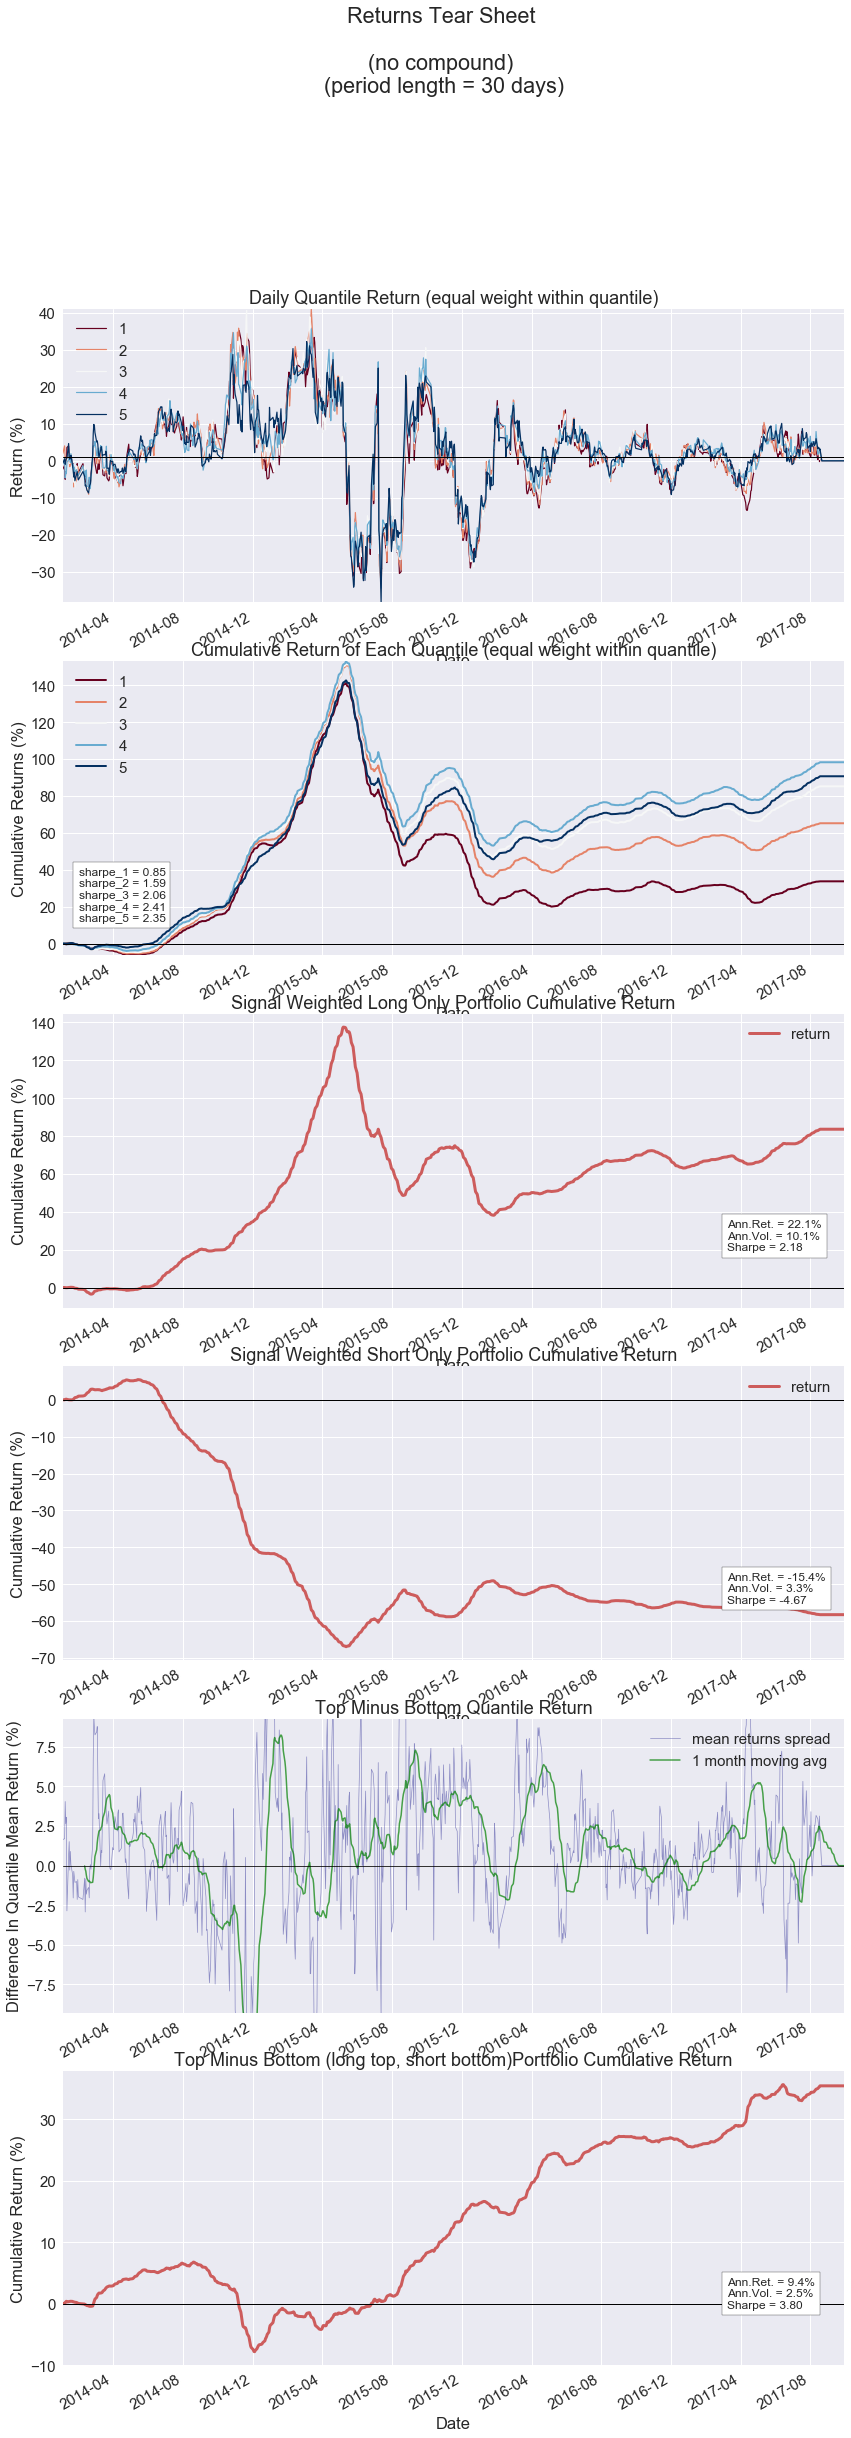

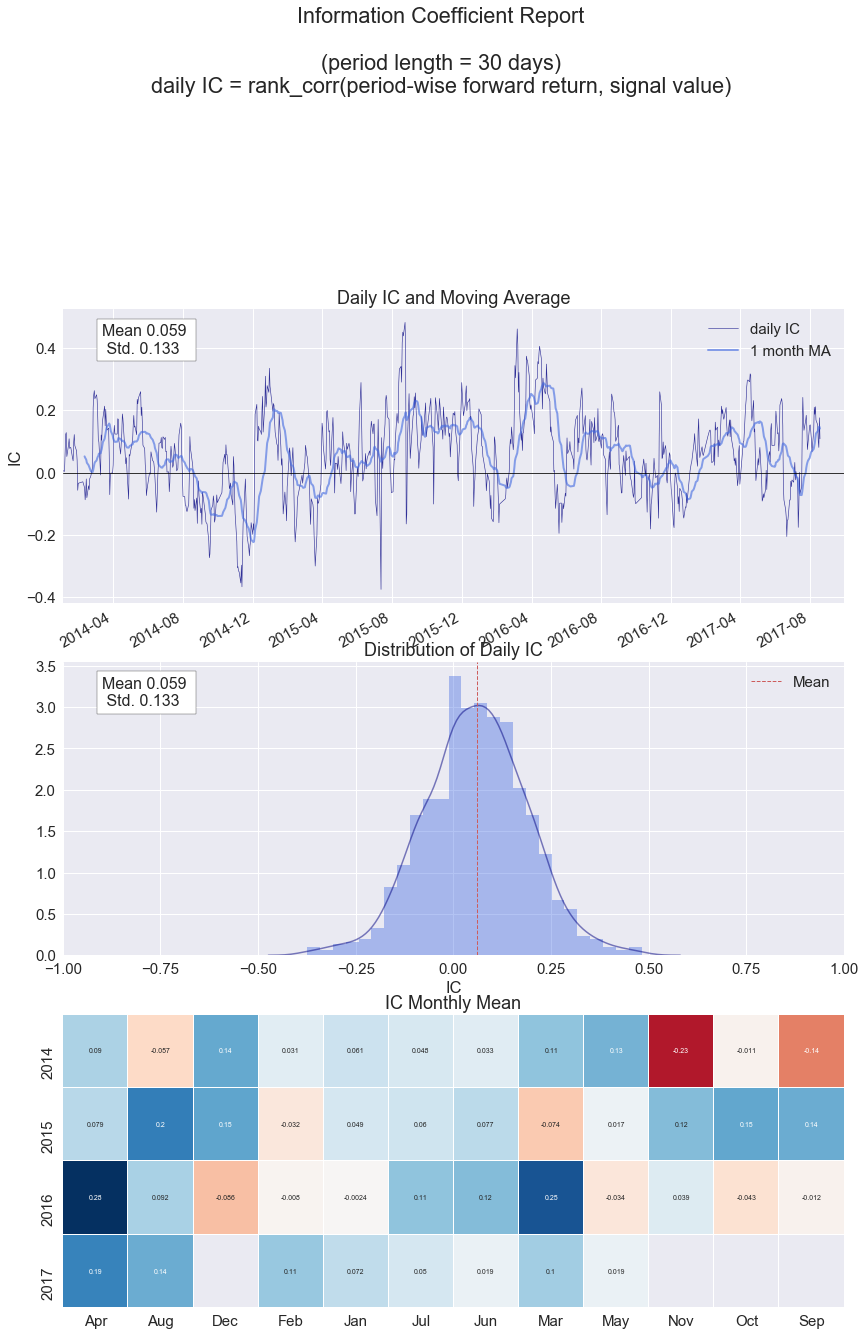

In [9]:
draw_analysis(optimizer.all_signals[ret_best[0]["signal_name"]], period=30)

#### 样本内可视化



Value of signals of Different Quantiles Statistics
               min       max      mean       std  count    count %
quantile                                                          
1        -2.080126 -0.054923 -0.802377  0.108587  27335  20.149342
2        -0.910108  0.444112 -0.629030  0.159256  27131  19.998968
3        -0.852226  0.664258 -0.467972  0.211465  27124  19.993808
4        -0.772911  0.801471 -0.269276  0.249928  27131  19.998968
5        -0.644317  0.964493  0.119820  0.308311  26941  19.858914
Figure saved: D:\QTC\PythonQTC\course\4_Selection\Richard\returns_report.pdf
Information Analysis
                ic
IC Mean      0.050
IC Std.      0.138
t-stat(IC)   7.965
p-value(IC)  0.000
IC Skew     -0.278
IC Kurtosis  0.347
Ann. IR      0.361
Figure saved: D:\QTC\PythonQTC\course\4_Selection\Richard\information_report.pdf


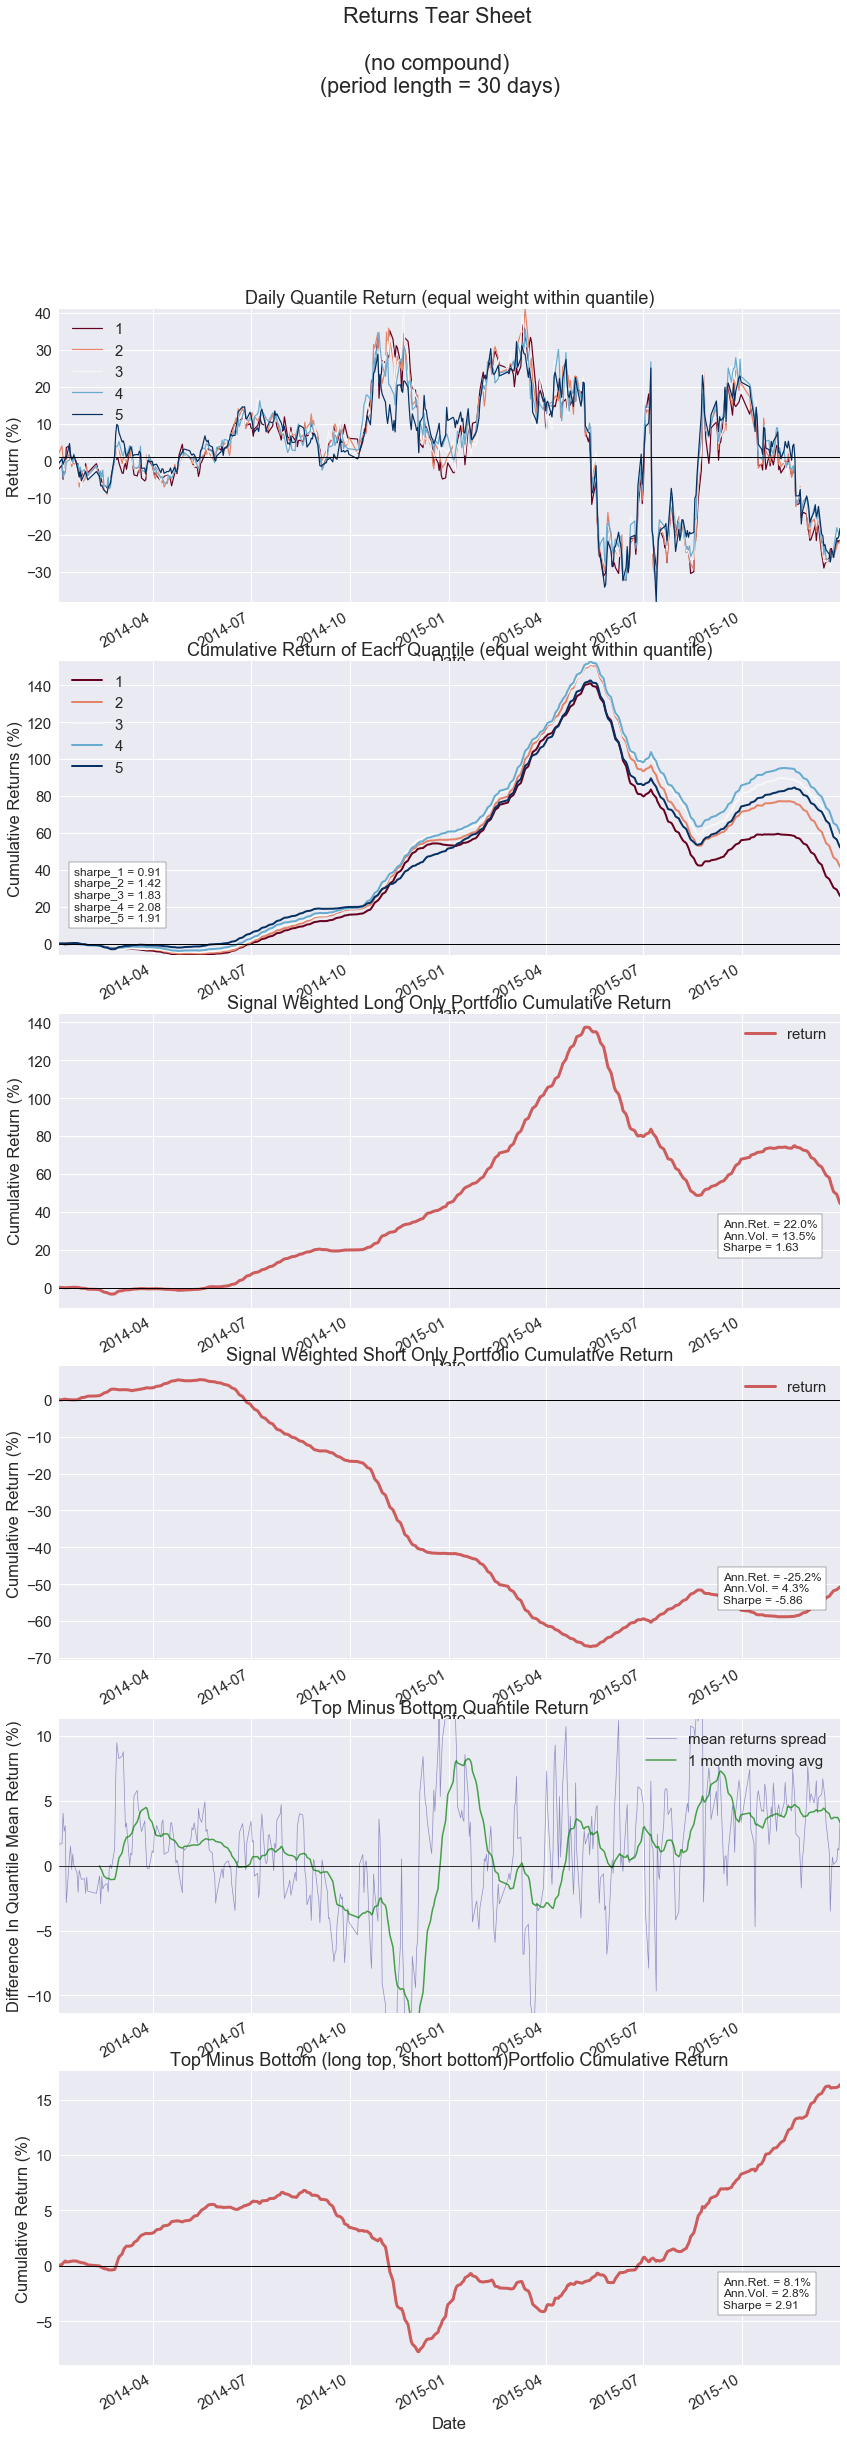

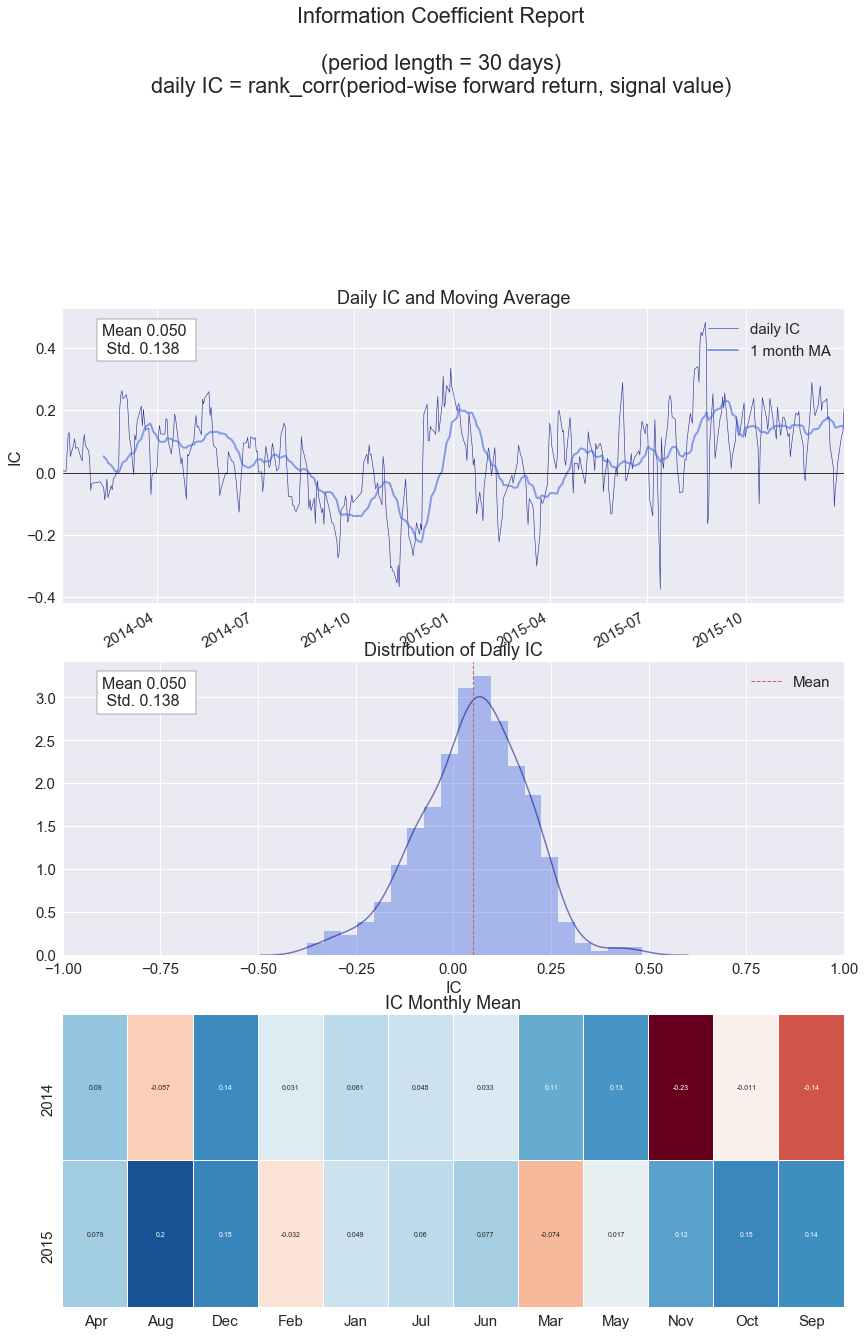

In [10]:
draw_analysis(optimizer.all_signals[ret_best[0]["signal_name"]].loc[20140101:20160101], period=30)

#### 样本外可视化



Value of signals of Different Quantiles Statistics
               min       max      mean       std  count    count %
quantile                                                          
1        -3.062545 -0.240942 -0.776234  0.113892  24451  20.139695
2        -0.906725  0.089250 -0.578515  0.145263  24287  20.004613
3        -0.826314  0.291378 -0.408492  0.178606  24269  19.989786
4        -0.744365  0.490119 -0.205701  0.206260  24287  20.004613
5        -0.616987  0.987630  0.175469  0.271961  24113  19.861293
Figure saved: D:\QTC\PythonQTC\course\4_Selection\Richard\returns_report.pdf
Information Analysis
                 ic
IC Mean       0.071
IC Std.       0.126
t-stat(IC)   11.197
p-value(IC)   0.000
IC Skew       0.272
IC Kurtosis  -0.239
Ann. IR       0.561
Figure saved: D:\QTC\PythonQTC\course\4_Selection\Richard\information_report.pdf


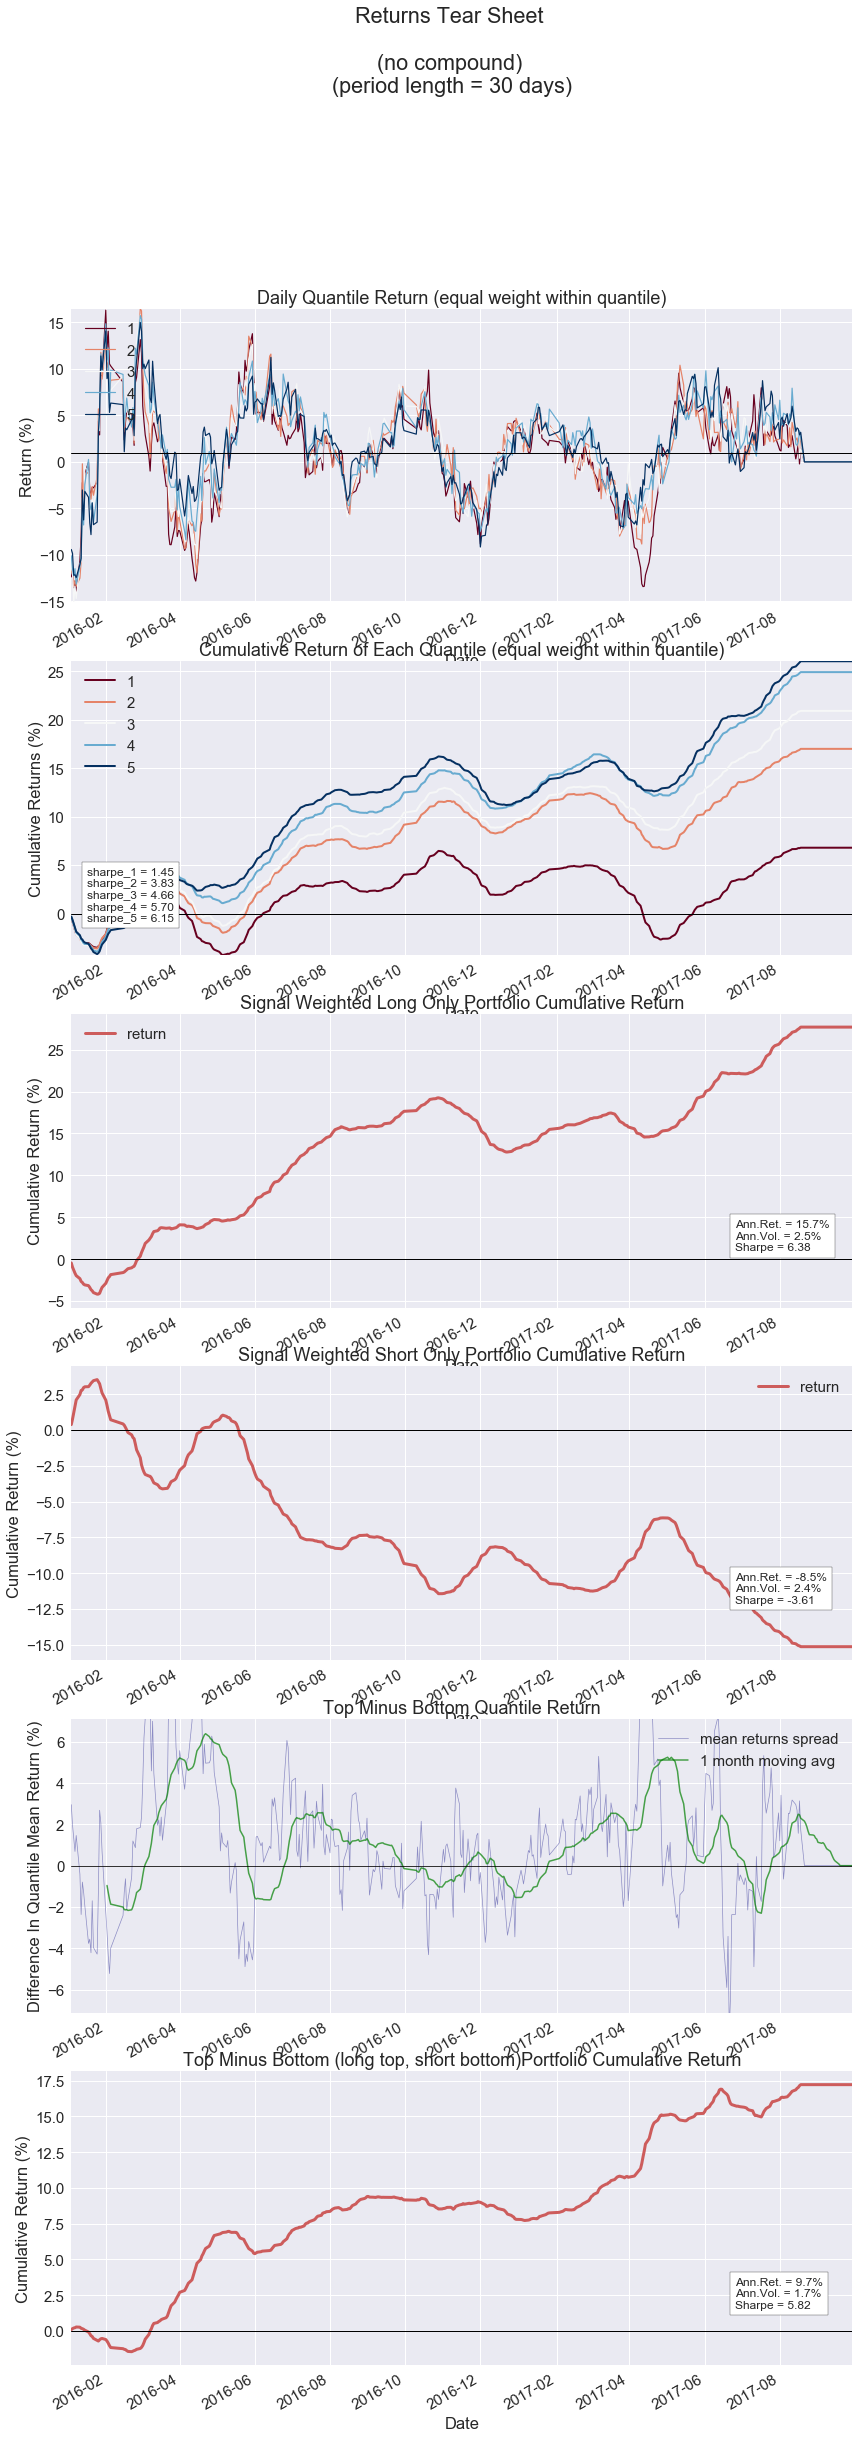

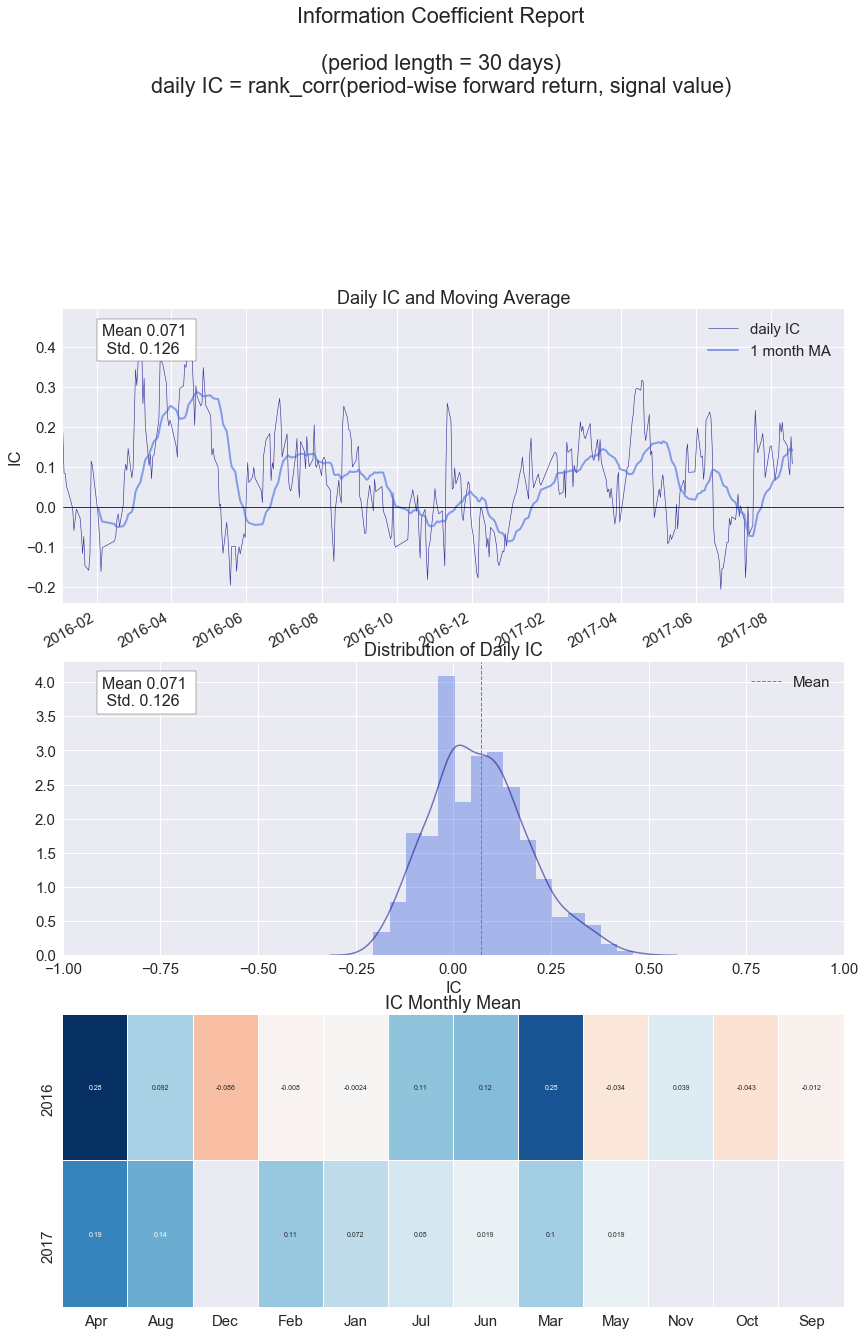

In [11]:
draw_analysis(optimizer.all_signals[ret_best[0]["signal_name"]].loc[20160101:], period=30)

In [12]:
# 以持有期mean_ic为最优化目标
ic_best = optimizer.enumerate_optimizer(target_type="return_ic",#优化目标类型
                                        target = "IC Mean",
                                        in_sample_range=[20140101,20160101],#样本内范围 默认为None,在全样本上优化
                                        ascending=False)                                  

In [13]:
print(ic_best[0]["signal_name"])
print(ic_best[0]["ic"])
print(ic_best[0]["ret"])
print(ic_best[0]["space"])

divert{'LEN': 12}
                return_ic  upside_ret_ic  downside_ret_ic
IC Mean      4.960313e-02       0.007377     6.425467e-02
IC Std.      1.375747e-01       0.136801     1.358379e-01
t-stat(IC)   7.964903e+00       1.191293     1.044946e+01
p-value(IC)  1.177710e-14       0.234119     3.385348e-23
IC Skew     -2.779783e-01      -0.167767     2.016567e-01
IC Kurtosis  3.472020e-01       0.873831     3.616037e-01
Ann. IR      3.605542e-01       0.053927     4.730247e-01
             long_ret   short_ret  long_short_ret  top_quantile_ret  \
t-stat       5.110799   -4.669524       -4.148759         33.349300   
p-value      0.000000    0.000000        0.000040          0.000000   
skewness    -0.575172    0.309078        0.122948          0.675351   
kurtosis    -0.018146   -0.320506       -0.141047          3.707588   
Ann. Ret     0.262372   -0.254147       -0.197867          0.308727   
Ann. Vol     0.398883    0.422892        0.370571          0.534983   
Ann. IR      0.657766

In [14]:
excel_data = optimizer.all_signals[ret_best[0]["signal_name"]][optimizer.all_signals[ret_best[0]["signal_name"]]['quantile']==5]["quantile"].unstack().replace(np.nan, 0).replace(5, 1)
print (excel_data.head())
excel_data.to_excel('./divert_opt_quantile_5.xlsx')

symbol      000001.SZ  000002.SZ  000008.SZ  000009.SZ  000012.SZ  000024.SZ  \
trade_date                                                                     
20140103          1.0        0.0        0.0        0.0        0.0        1.0   
20140106          0.0        0.0        0.0        0.0        0.0        1.0   
20140107          0.0        1.0        0.0        0.0        1.0        1.0   
20140108          0.0        1.0        0.0        0.0        1.0        1.0   
20140109          0.0        0.0        0.0        0.0        0.0        1.0   

symbol      000027.SZ  000039.SZ  000046.SZ  000060.SZ    ...      601992.SH  \
trade_date                                                ...                  
20140103          0.0        0.0        1.0        0.0    ...            0.0   
20140106          0.0        0.0        1.0        0.0    ...            1.0   
20140107          0.0        0.0        1.0        0.0    ...            0.0   
20140108          0.0        0.0       

## 2. 事件参数优化

In [15]:
event_opt = Optimizer(dataview=dv,
                      formula="(Ts_Mean(close_adj, SHORT)>=Ts_Mean(close_adj, LONG))&&(Delay(Ts_Mean(close_adj, SHORT)<Ts_Mean(close_adj, LONG), 1))",
                      params={'SHORT':range(5,11,1),'LONG':range(30,61,5)},
                      name='cross',
                      price=price,
                      high=high,
                      low=low,
                      benchmark_price=None,#=None求绝对收益 #=price_bench求相对收益
                      period=30,
                      n_quantiles=1,
                      mask=mask,
                      can_enter=can_enter,
                      can_exit=can_exit,
                      commission=0.0008,#手续费 默认0.0008
                      is_event=True,#是否是事件(0/1因子)
                      is_quarterly=False)#是否是季度因子 默认为False

In [16]:
event_best = event_opt.enumerate_optimizer(target_type="long_ret",
                                           target="Ann. IR",
                                           in_sample_range=[20140101,20160101],#样本内范围 默认为None,在全样本上优化
                                           ascending=False)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective da

In [17]:
# 事件样本内最优绩效 ps：事件没有ic分析结果
# 可以进一步尝试优化space，辅以更精细的择时捕捉事件收益
print(event_best[0]["signal_name"])
print(event_best[0]["ret"])
print(event_best[0]["space"])

cross{'SHORT': 10, 'LONG': 55}
              long_ret  long_short_ret
t-stat       12.373617        3.432911
p-value       0.000000        0.000670
skewness      1.005173       -0.019307
kurtosis      4.215504        0.981804
Ann. Ret      0.456521        0.238228
Ann. Vol      0.496016        0.447872
Ann. IR       0.920375        0.531912
occurance  1459.000000      337.000000
                   long_space
Ann. Up_sp Ret       1.336951
Ann. Up_sp Vol       0.470803
Ann. Up_sp IR        2.839727
Up_sp Pct5           0.004526
Up_sp Pct25          0.049561
Up_sp Pct50          0.118951
Up_sp Pct75          0.234501
Up_sp Pct95          0.475594
Up_sp Occur       1459.000000
Ann. Down_sp Ret    -0.660363
Ann. Down_sp Vol     0.257381
Ann. Down_sp IR     -2.565700
Down_sp Pct5        -0.291374
Down_sp Pct25       -0.104825
Down_sp Pct50       -0.053169
Down_sp Pct75       -0.023307
Down_sp Pct95       -0.003920
Down_sp Occur     1459.000000


#### 可视化



Value of signals of Different Quantiles Statistics
          min  max      mean       std   count  count %
quantile                                               
1         0.0  1.0  0.012066  0.109179  252621    100.0
Figure saved: D:\QTC\PythonQTC\course\4_Selection\Richard\returns_report.pdf
Information Analysis
                ic
IC Mean     -0.006
IC Std.      0.066
t-stat(IC)  -2.326
p-value(IC)  0.020
IC Skew     -0.083
IC Kurtosis  0.033
Ann. IR     -0.091
Figure saved: D:\QTC\PythonQTC\course\4_Selection\Richard\information_report.pdf


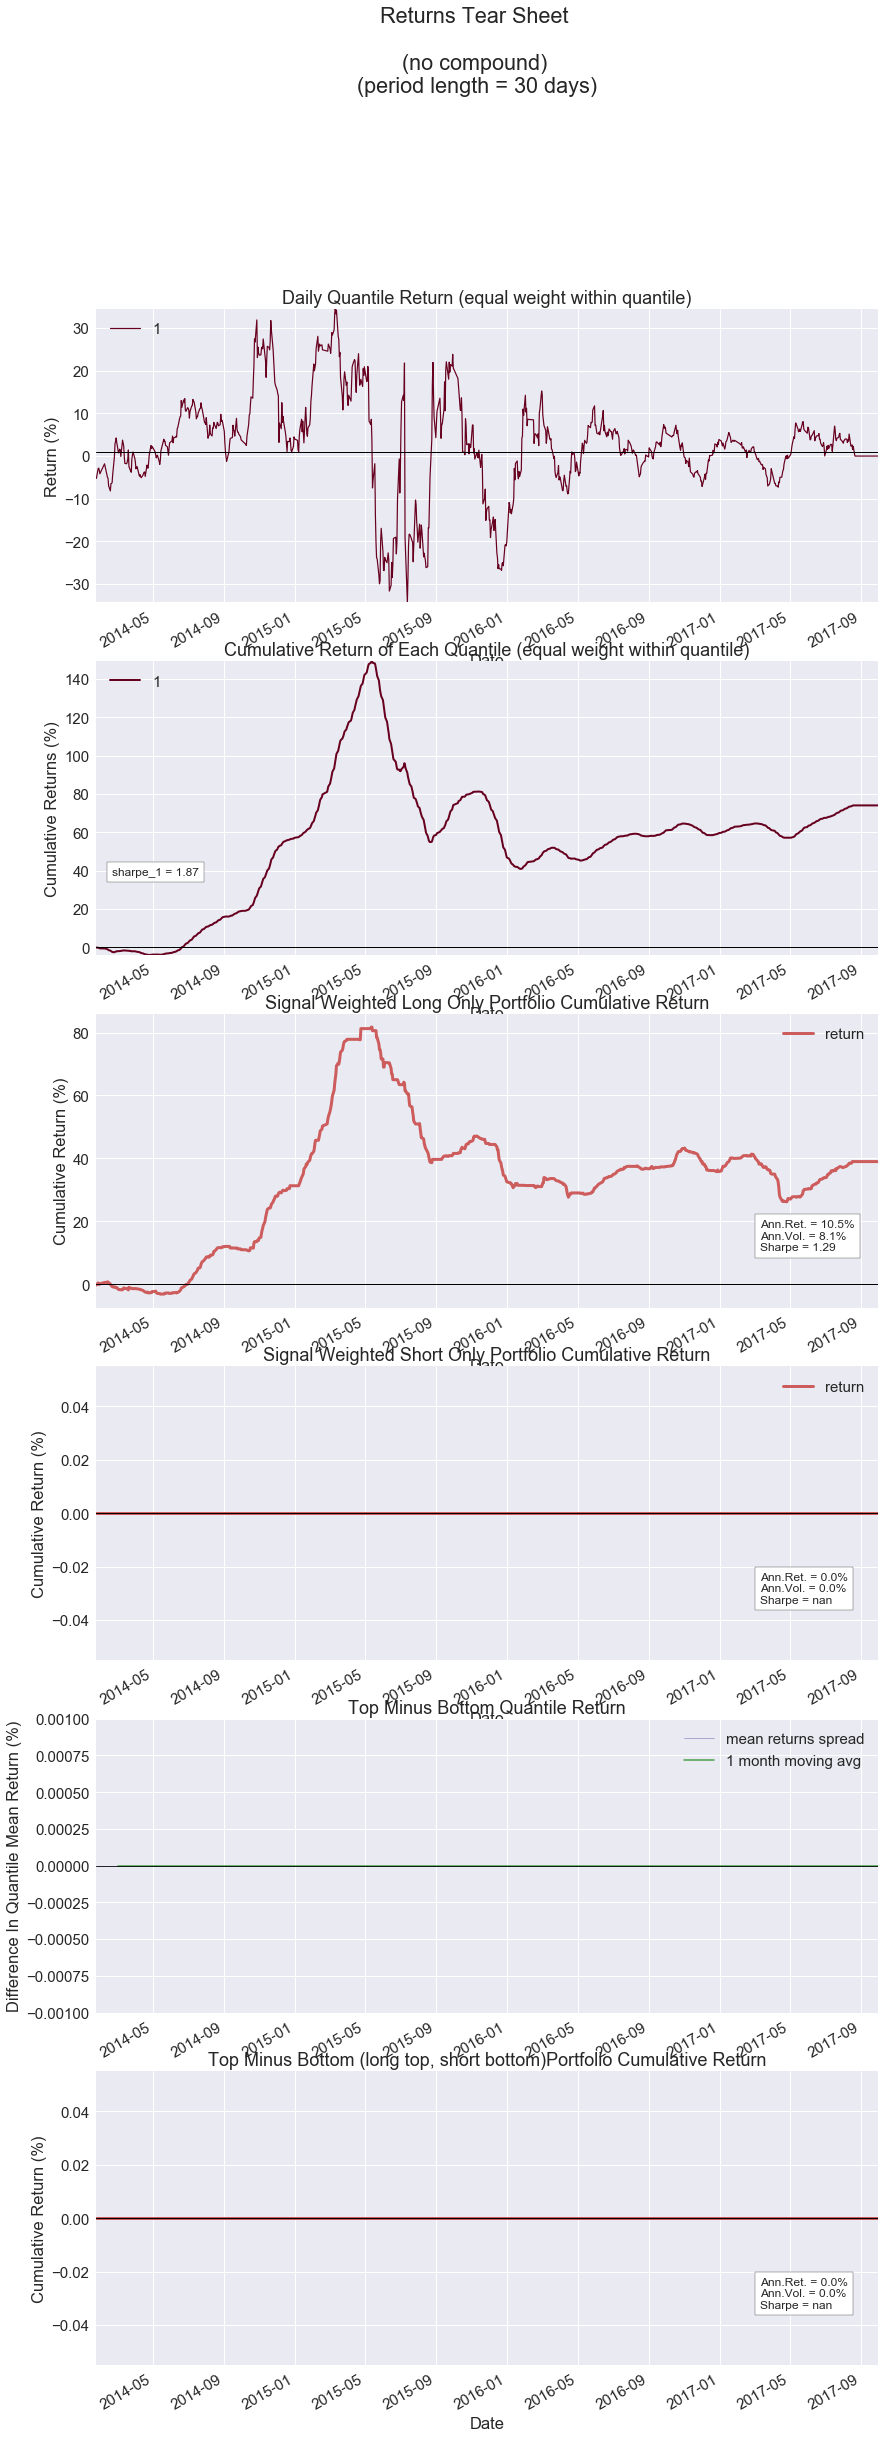

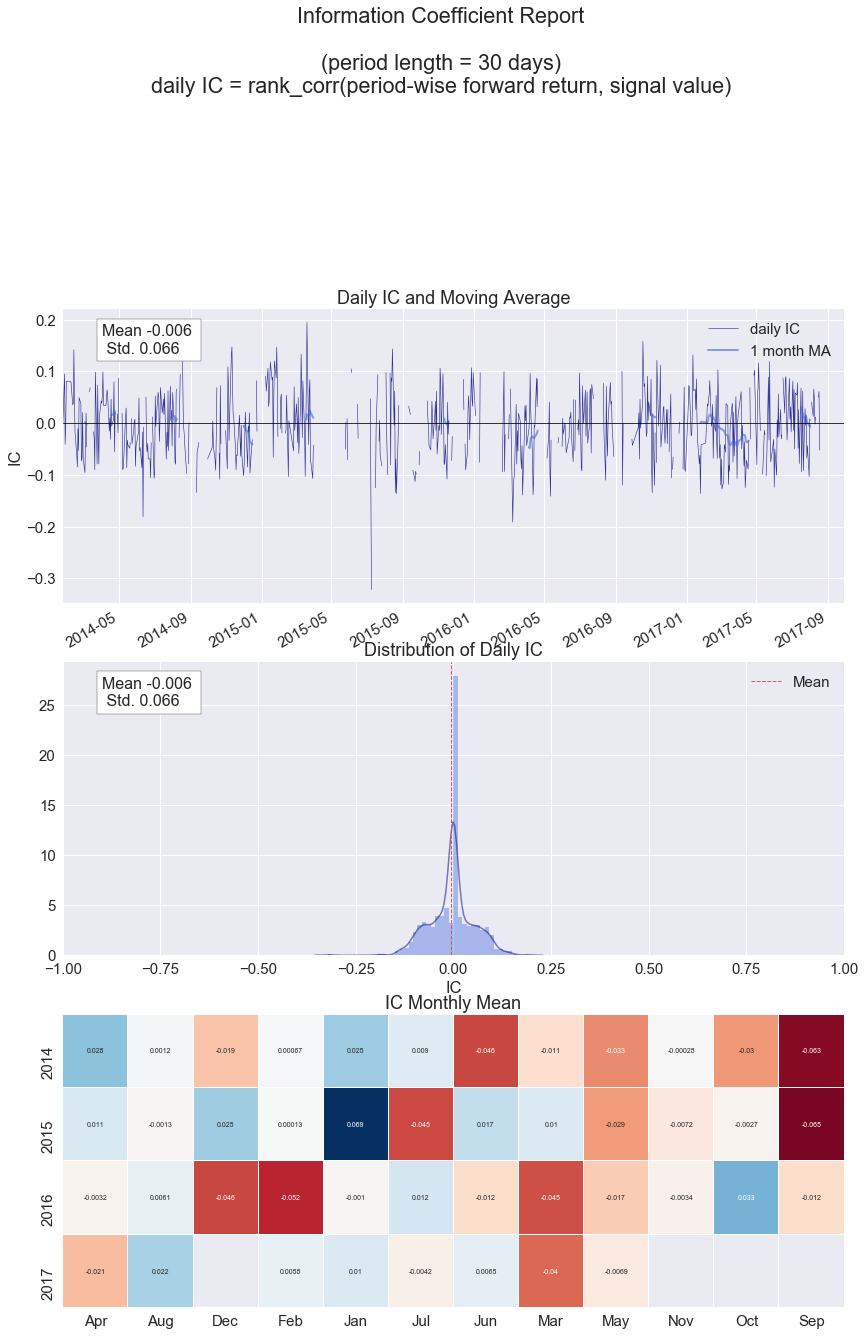

In [18]:
# 全样本
draw_analysis(event_opt.all_signals[event_best[0]["signal_name"]], period=30)



Value of signals of Different Quantiles Statistics
          min  max      mean       std   count  count %
quantile                                               
1         0.0  1.0  0.011119  0.104859  131218    100.0
Figure saved: D:\QTC\PythonQTC\course\4_Selection\Richard\returns_report.pdf
Information Analysis
                ic
IC Mean     -0.004
IC Std.      0.068
t-stat(IC)  -1.135
p-value(IC)  0.257
IC Skew     -0.098
IC Kurtosis  0.562
Ann. IR     -0.062
Figure saved: D:\QTC\PythonQTC\course\4_Selection\Richard\information_report.pdf


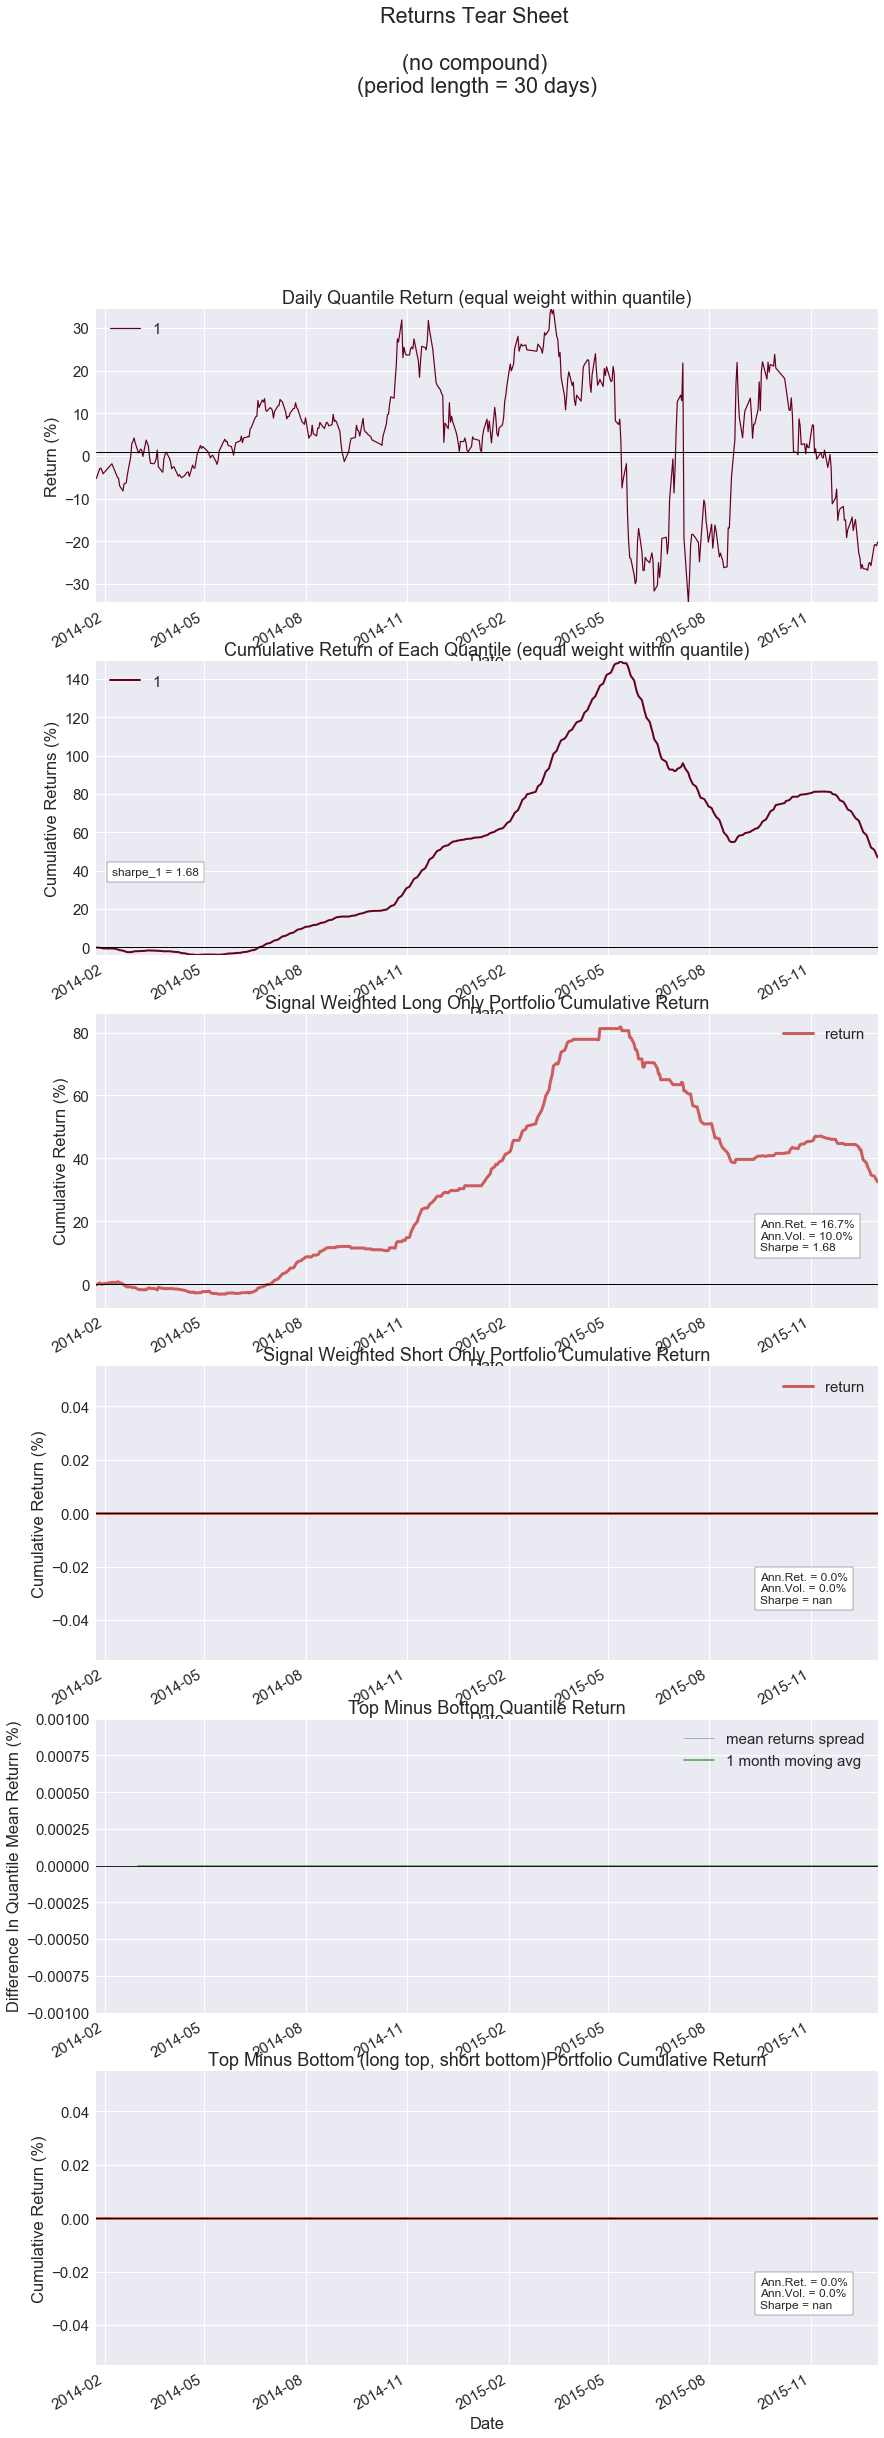

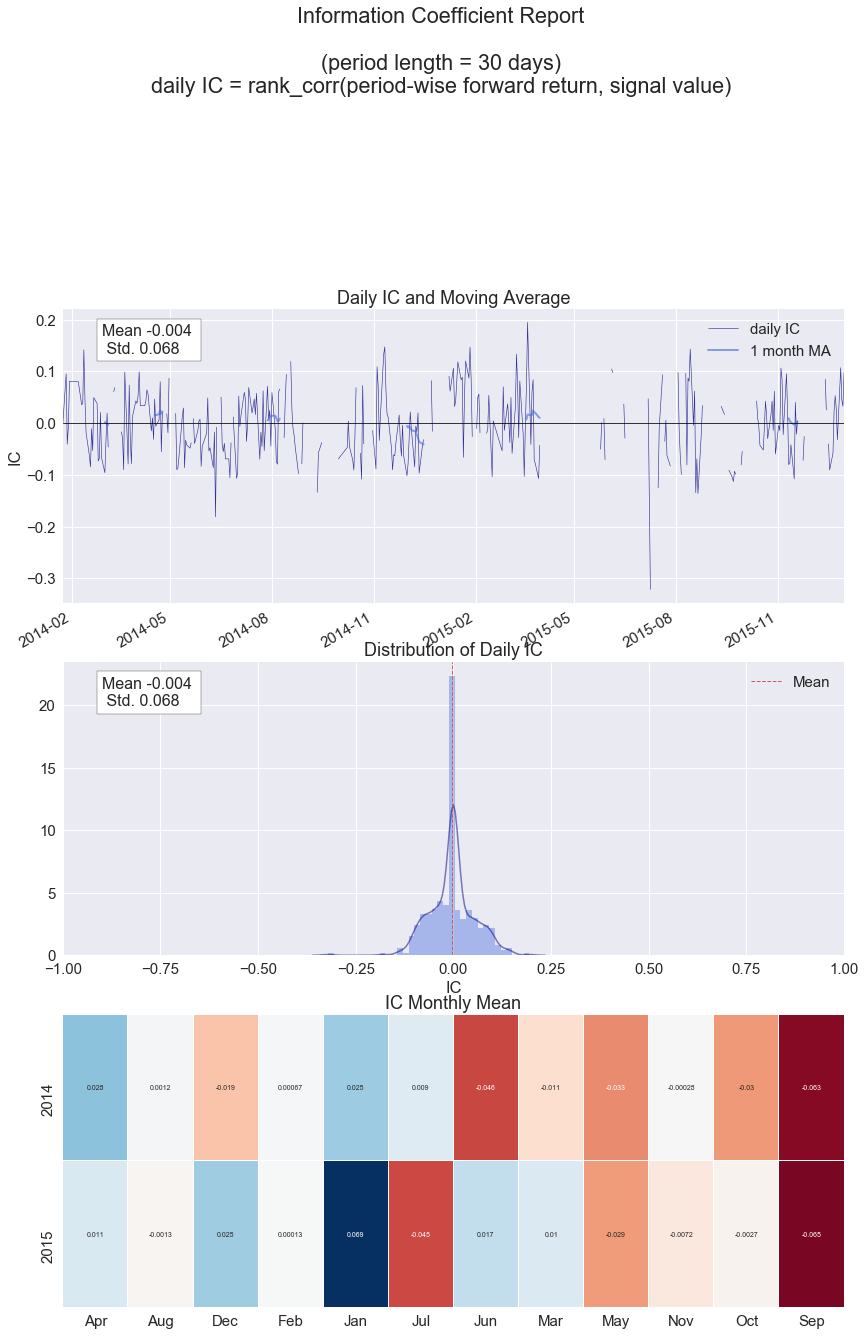

In [19]:
# 样本内
draw_analysis(event_opt.all_signals[event_best[0]["signal_name"]].loc[20140101:20160101], period=30)



Value of signals of Different Quantiles Statistics
          min  max      mean       std   count  count %
quantile                                               
1         0.0  1.0  0.013089  0.113655  121403    100.0
Figure saved: D:\QTC\PythonQTC\course\4_Selection\Richard\returns_report.pdf
Information Analysis
                ic
IC Mean     -0.008
IC Std.      0.065
t-stat(IC)  -2.204
p-value(IC)  0.028
IC Skew     -0.073
IC Kurtosis -0.674
Ann. IR     -0.125
Figure saved: D:\QTC\PythonQTC\course\4_Selection\Richard\information_report.pdf


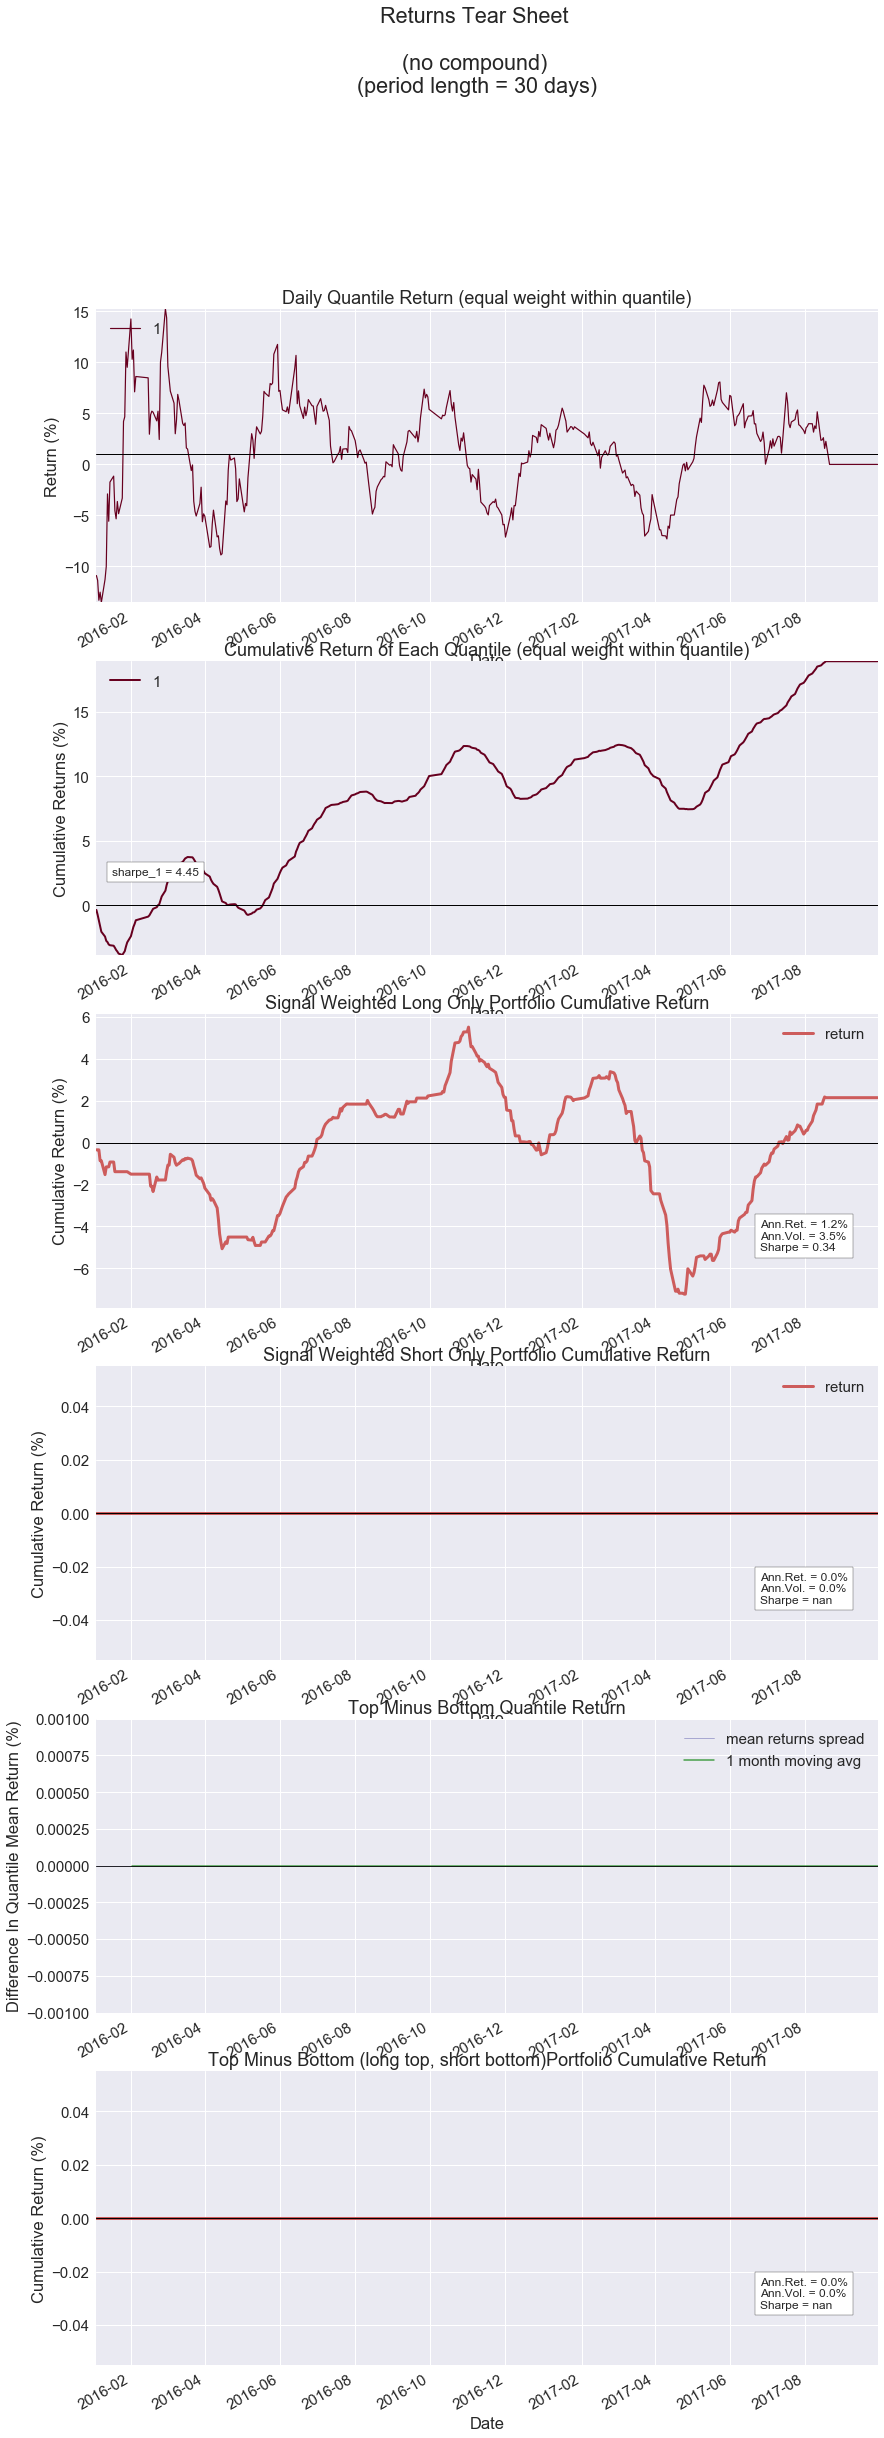

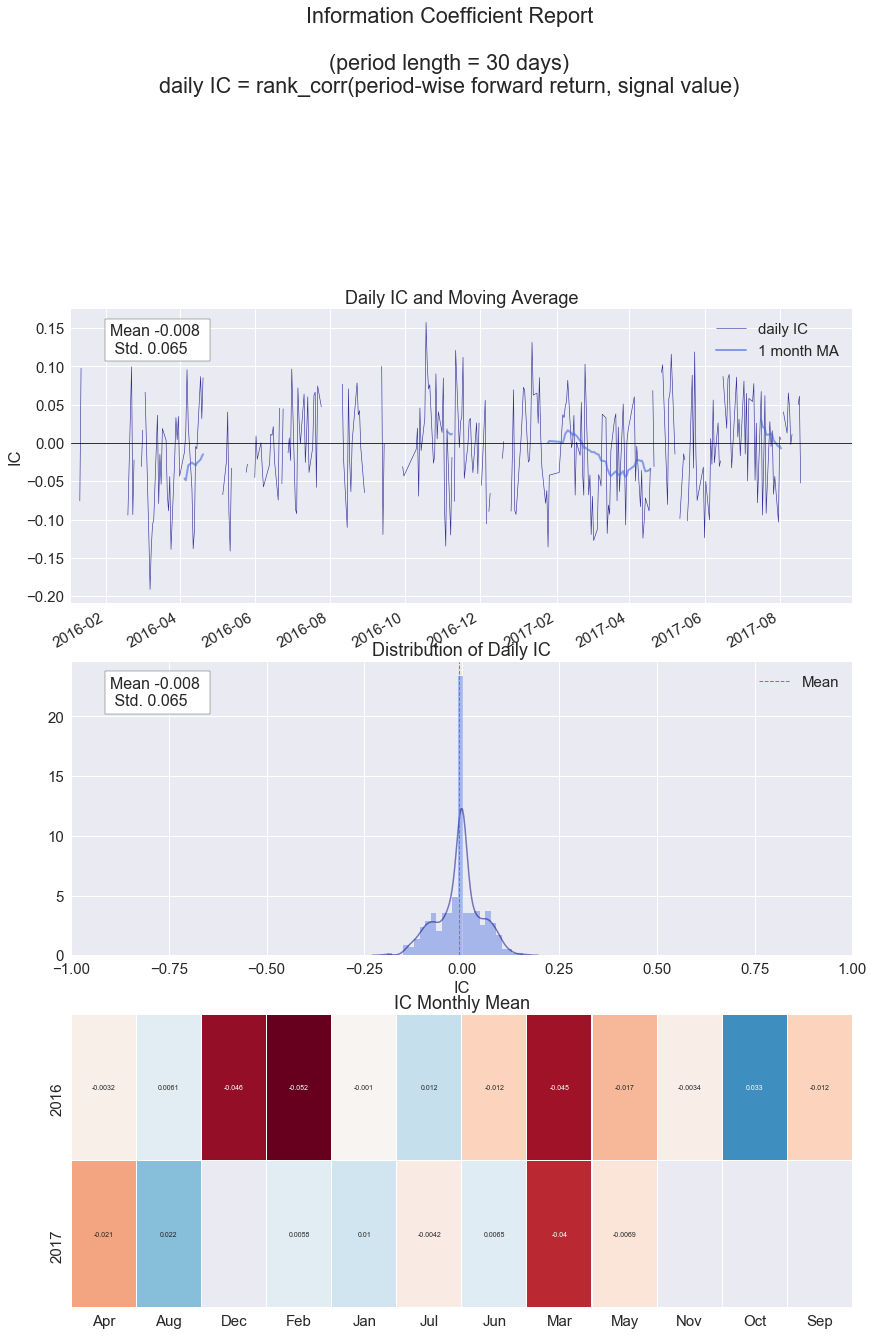

In [20]:
# 样本外
draw_analysis(event_opt.all_signals[event_best[0]["signal_name"]].loc[20160101:], period=30)

## 3. 拓展：外部自定义带参算法优化

In [21]:
import pandas as pd
import talib as ta

slp_opt =   Optimizer(dataview=dv,
                      price=price,
                      period=30,
                      n_quantiles=5,
                      mask=mask,
                      can_enter=can_enter,
                      can_exit=can_exit,
                      commission=0.0008,#手续费 默认0.0008
                      is_event=False,#是否是事件(0/1因子)
                      is_quarterly=False)#是否是季度因子 默认为False

signals_dict = {}
for param in range(2,9,1):
    slope_df = pd.DataFrame({name: -ta.LINEARREG_SLOPE(value.values, param) for name, value in price.iteritems()}, index=price.index)
    dv.append_df(slope_df,'SLOPE_PARAM='+str(param))
    signals_dict['SLOPE_PARAM='+str(param)] = slp_opt.cal_signal(dv.get_ts('SLOPE_PARAM='+str(param)))

Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%


In [22]:
slp_opt.all_signals = signals_dict

In [23]:
# 以持有期mean_ic为最优化目标
slp_best = slp_opt.enumerate_optimizer(target_type="return_ic",#优化目标类型
                                       target = "IC Mean",
                                       in_sample_range=[20140101,20160101],#样本内范围 默认为None,在全样本上优化
                                       ascending=False)                                         

In [24]:
# 样本内绩效
print(slp_best[0]["signal_name"])
print(slp_best[0]["ic"])
print(slp_best[0]["ret"])

SLOPE_PARAM=8
                return_ic
IC Mean      4.299888e-02
IC Std.      1.617011e-01
t-stat(IC)   5.831988e+00
p-value(IC)  1.007307e-08
IC Skew      5.618541e-02
IC Kurtosis  2.089043e-01
Ann. IR      2.659157e-01
             long_ret   short_ret  long_short_ret  top_quantile_ret  \
t-stat       3.819634   -1.719541        0.505166         32.283237   
p-value      0.000150    0.086160        0.613670          0.000000   
skewness    -0.248871    0.321936        0.200769          0.931792   
kurtosis    -0.149910   -0.288344        0.662554          4.240505   
Ann. Ret     0.210085   -0.095689        0.019640          0.312823   
Ann. Vol     0.424275    0.428817        0.299911          0.555819   
Ann. IR      0.495163   -0.223147        0.065488          0.562815   
occurance  481.000000  480.000000      481.000000      26542.000000   

           bottom_quantile_ret     tmb_ret  
t-stat               18.988489    5.454760  
p-value               0.000000    0.000000  
ske